# plot revolutions

1. Identify peaks and troughs in the signal
2. A movement occurs between peak-trough pairs

```
csf  = s[1]["trl"]
cg   = s[2]["trl"]
ebl  = s[3]["trl"]
rand = s[4]["trl"]
sfg  = s[5]["trl"]
```

### imports

In [59]:
using PyPlot
using PyCall
using Printf
using Statistics
include("spike_utils.jl")

pyabf = pyimport("pyabf");
sns = pyimport("seaborn");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["figure.figsize"] = (16,10)
sns.set_context("talk")

### parameters

In [60]:
files = [
    "data/19o09013-fly2-csf-cont-ccw-5s-2so.abf"
    "data/19o09014-fly2-cg-cont-ccw-5s-2so.abf"
    "data/19o09014-fly2-ebl-cont-ccw-5s-2so.abf"
    "data/19o09015-fly2-random-cont-ccw-5s-2so.abf"
    "data/19o09016-fly2-sfg-cont-ccw-5s-2so.abf"
];

In [61]:
sccw = Dict()
for i = 1 : length(files)
    # Load the file
    sccw[i] = Dict()
    spk, stim, t, srate, pts_per_ms = load_fly_data(files[i])
    sccw[i]["filepath"]   = files[i]
    sccw[i]["spk"]        = spk
    sccw[i]["stim"]       = stim
    sccw[i]["t"]          = t
    sccw[i]["srate"]      = srate
    sccw[i]["pts_per_ms"] = pts_per_ms
    # Spike-sort
    sccw[i]["THRESHOLD"]  = -2.5 * std(sccw[i]["spk"])
    sccw[i]["SPK_WIN_MS"] = 6
    sccw[i]["spkidx"]     = get_thresholded_spikes(sccw[i]["spk"], sccw[i]["THRESHOLD"], sccw[i]["SPK_WIN_MS"]*sccw[i]["pts_per_ms"])
    sccw[i]["wfs"], sccw[i]["tspk"] = collect_waveforms(sccw[i]["spk"], sccw[i]["spkidx"], sccw[i]["SPK_WIN_MS"], sccw[i]["pts_per_ms"])
    sccw[i]["toremoveidx"], sccw[i]["peaks"], sccw[i]["troughs"] = check_bad_wfs(sccw[i]["wfs"], sccw[i]["tspk"]); 
    # Mark separate stimulus drum cycles
    sccw[i]["cycle_idx"], sccw[i]["starting_val"] = mark_cycles(sccw[i])
    sccw[i] = collect_cycles(sccw[i])
    # Compute instantaneous firing rates
    SIZE_MS = 300
    # window = DSP.Windows.rect(SIZE_MS * sccw[1]["pts_per_ms"])
    sccw[i] = compute_trl_frs(sccw[i], ones(SIZE_MS * sccw[1]["pts_per_ms"]))
#     sccw[i] = compute_trl_frs_isi_reciprocal(sccw[i], sccw[1]["pts_per_ms"])
    # Plot the results for this file
    #summarize_session(s[i])
end

MethodError: MethodError: no method matching compute_trl_frs(::Dict{Any,Any}, ::Array{Float64,1})
Closest candidates are:
  compute_trl_frs(::Any, ::Any, !Matched::Any) at /Users/jorge/Dropbox (MIT)/school/Princeton/neu501b/h1/spike_utils.jl:299

In [4]:
for isess = 1 : length(sccw)
    lengths = []
    for i = 1 : length(sccw[isess]["trl"])
        push!(lengths, length(sccw[isess]["trl"][i]["ifr"]))
    end
    minlength = minimum(lengths)
    ifrs = zeros(length(sccw[isess]["trl"]), minlength);
    for i = 1 : length(sccw[isess]["trl"])
        ifrs[i,:] = sccw[isess]["trl"][i]["ifr"][1:minlength]
    end
    sccw[isess]["t_ifr"] = range(0, minlength/sccw[isess]["pts_per_ms"]/1000, length=minlength)
    sccw[isess]["ifrs"] = ifrs';
    sccw[isess]["ifr"] = mean(ifrs, dims=1)'
end
for isess = 1 : length(sccw)
    ci95 = 1.96 .* std(sccw[isess]["ifrs"], dims=2) ./ sqrt(length(sccw[isess]["trl"]))
    plot(sccw[isess]["t_ifr"], sccw[isess]["ifr"], label=sccw[isess]["filepath"], alpha=0.8)
    fill_between(sccw[isess]["t_ifr"], dropdims(sccw[isess]["ifr"]-ci95, dims=2), dropdims(sccw[isess]["ifr"]+ci95, dims=2), alpha=0.5)
end

xlim([0, 6]);
legend()

KeyError: KeyError: key "ifr" not found

In [38]:
files = [
    "data/19o09013-fly2-csf-cont-cw-5s-2so.abf"
    "data/19o09015-fly2-cg-cont-cw-5s-2so.abf"
    "data/19o09014-fly2-ebl-cont-cw-5s-2so.abf"
    "data/19o09015-fly2-random-cont-cw-5s-2so.abf"
];

scw = Dict()
for i = 1 : length(files)
    # Load the file
    scw[i] = Dict()
    spk, stim, t, srate, pts_per_ms = load_fly_data(files[i])
    scw[i]["filepath"]   = files[i]
    scw[i]["spk"]        = spk
    scw[i]["stim"]       = stim
    scw[i]["t"]          = t
    scw[i]["srate"]      = srate
    scw[i]["pts_per_ms"] = pts_per_ms
    # Spike-sort
    scw[i]["THRESHOLD"]  = -2.5 * std(scw[i]["spk"])
    scw[i]["SPK_WIN_MS"] = 6
    scw[i]["spkidx"]     = get_thresholded_spikes(scw[i]["spk"], scw[i]["THRESHOLD"], scw[i]["SPK_WIN_MS"]*scw[i]["pts_per_ms"])
    scw[i]["wfs"], scw[i]["tspk"] = collect_waveforms(scw[i]["spk"], scw[i]["spkidx"], scw[i]["SPK_WIN_MS"], scw[i]["pts_per_ms"])
    scw[i]["toremoveidx"], scw[i]["peaks"], scw[i]["troughs"] = check_bad_wfs(scw[i]["wfs"], scw[i]["tspk"]); 
    # Mark separate stimulus drum cycles
    scw[i]["cycle_idx"], scw[i]["starting_val"] = mark_cycles(scw[i])
    scw[i] = collect_cycles(scw[i])
    # Compute instantaneous firing rates
    SIZE_MS = 300
    # window = DSP.Windows.rect(SIZE_MS * scw[1]["pts_per_ms"])
    scw[i] = compute_trl_frs(scw[i], ones(SIZE_MS * scw[1]["pts_per_ms"]))
    # Plot the results for this file
    #summarize_session(s[i])
end

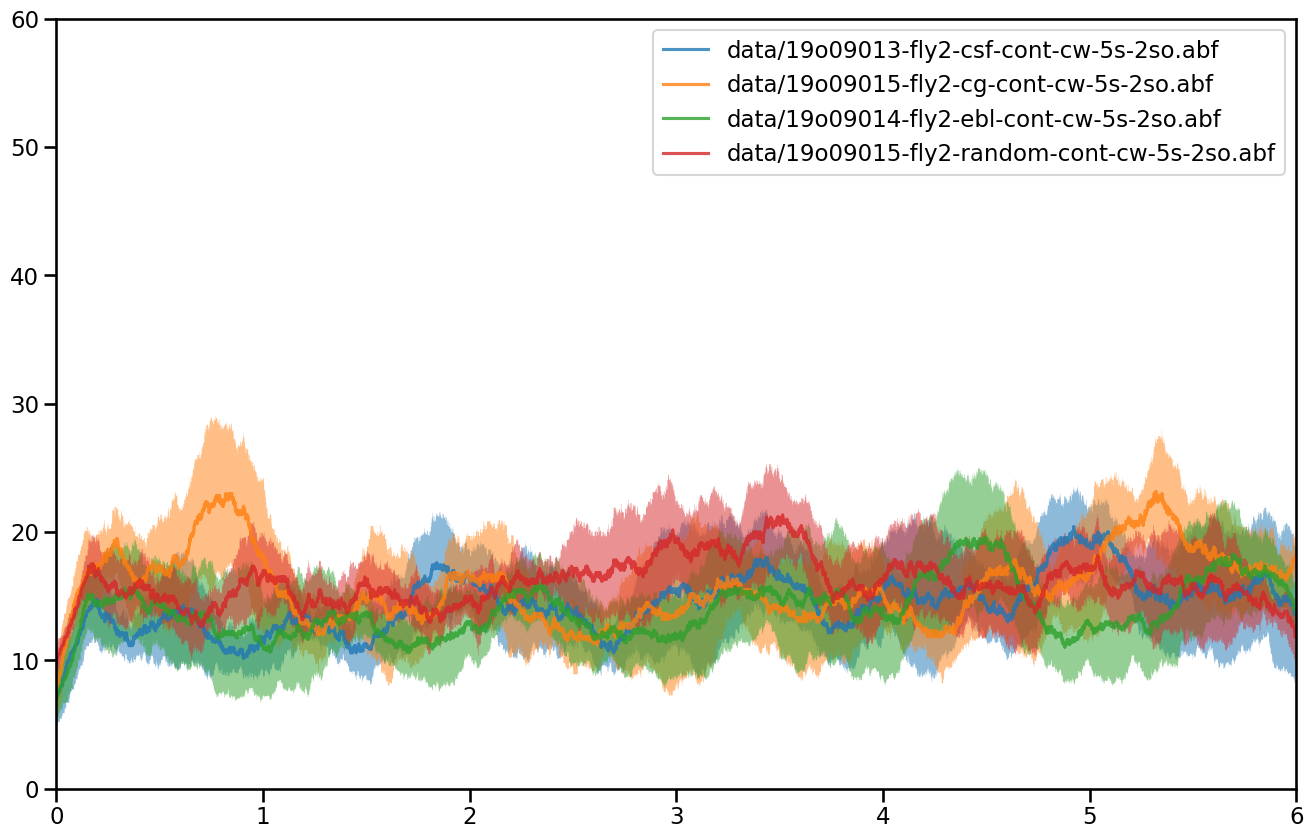

In [39]:
for isess = 1 : length(scw)
    lengths = []
    for i = 1 : length(scw[isess]["trl"])
        push!(lengths, length(scw[isess]["trl"][i]["ifr"]))
    end
    minlength = minimum(lengths)
    ifrs = zeros(length(scw[isess]["trl"]), minlength);
    for i = 1 : length(scw[isess]["trl"])
        ifrs[i,:] = scw[isess]["trl"][i]["ifr"][1:minlength]
    end
    scw[isess]["t_ifr"] = range(0, minlength/scw[isess]["pts_per_ms"]/1000, length=minlength)
    scw[isess]["ifrs"] = ifrs';
    scw[isess]["ifr"] = mean(ifrs, dims=1)'
end
for isess = 1 : length(scw)
    ci95 = 1.96 .* std(scw[isess]["ifrs"], dims=2) ./ sqrt(length(scw[isess]["trl"]))
    plot(scw[isess]["t_ifr"], scw[isess]["ifr"], label=scw[isess]["filepath"], alpha=0.8)
    fill_between(scw[isess]["t_ifr"], dropdims(scw[isess]["ifr"]-ci95, dims=2), dropdims(scw[isess]["ifr"]+ci95, dims=2), alpha=0.5)
end
xlim([0, 6]) ; ylim([0, 60])

legend();

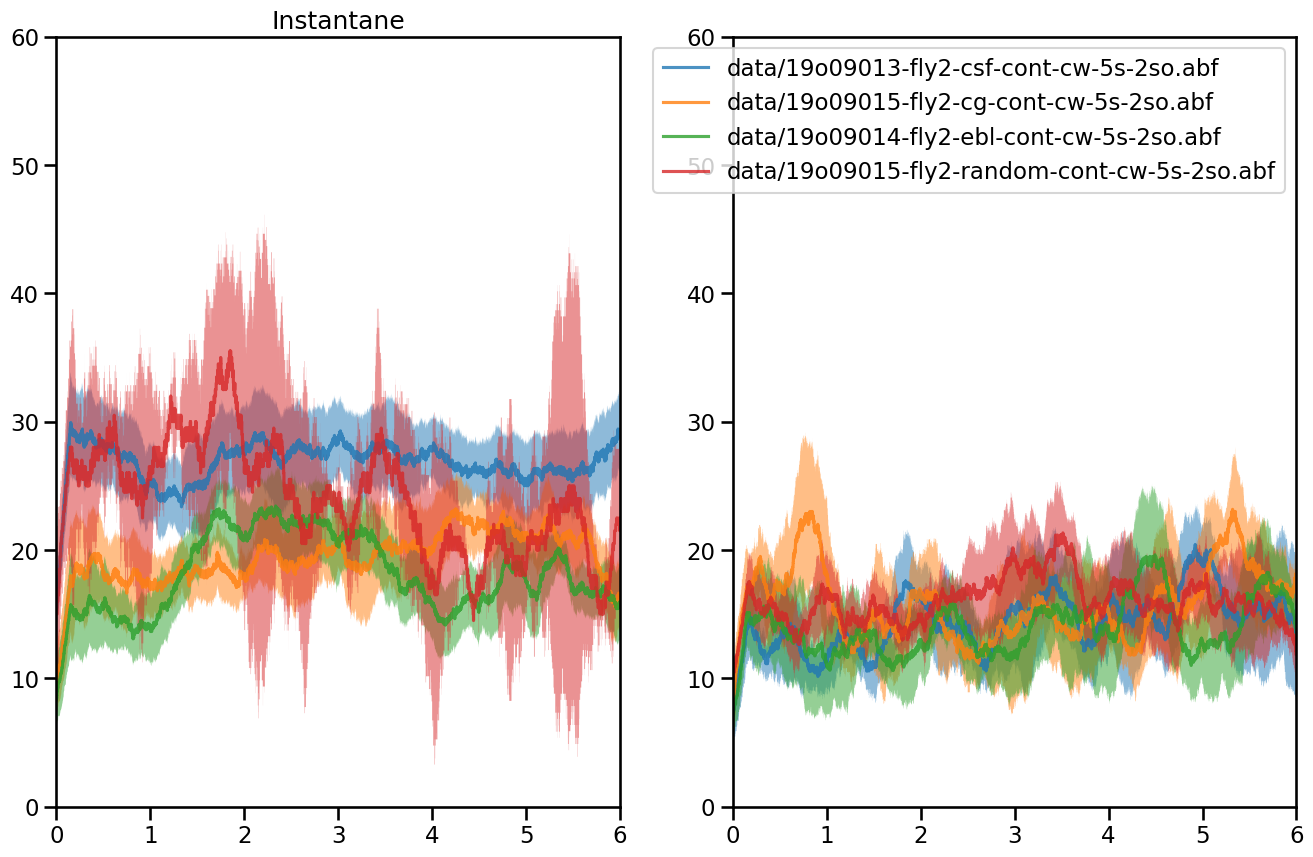

In [40]:
rcParams["figure.figsize"] = (16,10)
figure()
subplot(1,2,1);
for isess = 1 : length(sccw)
    sccw[isess]["ci95"] = 1.96 .* std(sccw[isess]["ifrs"], dims=2) ./ sqrt(length(sccw[isess]["trl"]))
    plot(sccw[isess]["t_ifr"], sccw[isess]["ifr"], label=sccw[isess]["filepath"], alpha=0.8)
    fill_between(sccw[isess]["t_ifr"], dropdims(sccw[isess]["ifr"]-sccw[isess]["ci95"], dims=2), dropdims(sccw[isess]["ifr"]+sccw[isess]["ci95"], dims=2), alpha=0.5)
end
title("Instantane")
xlim([0, 6]); ylim([0, 60])
# legend()

subplot(1,2,2);
for isess = 1 : length(scw)
    scw[isess]["ci95"] = 1.96 .* std(scw[isess]["ifrs"], dims=2) ./ sqrt(length(scw[isess]["trl"]))
    plot(scw[isess]["t_ifr"], scw[isess]["ifr"], label=scw[isess]["filepath"], alpha=0.8)
    fill_between(scw[isess]["t_ifr"], dropdims(scw[isess]["ifr"]-scw[isess]["ci95"], dims=2), dropdims(scw[isess]["ifr"]+scw[isess]["ci95"], dims=2), alpha=0.5)
end
xlim([0, 6]) ; ylim([0, 60])

legend();

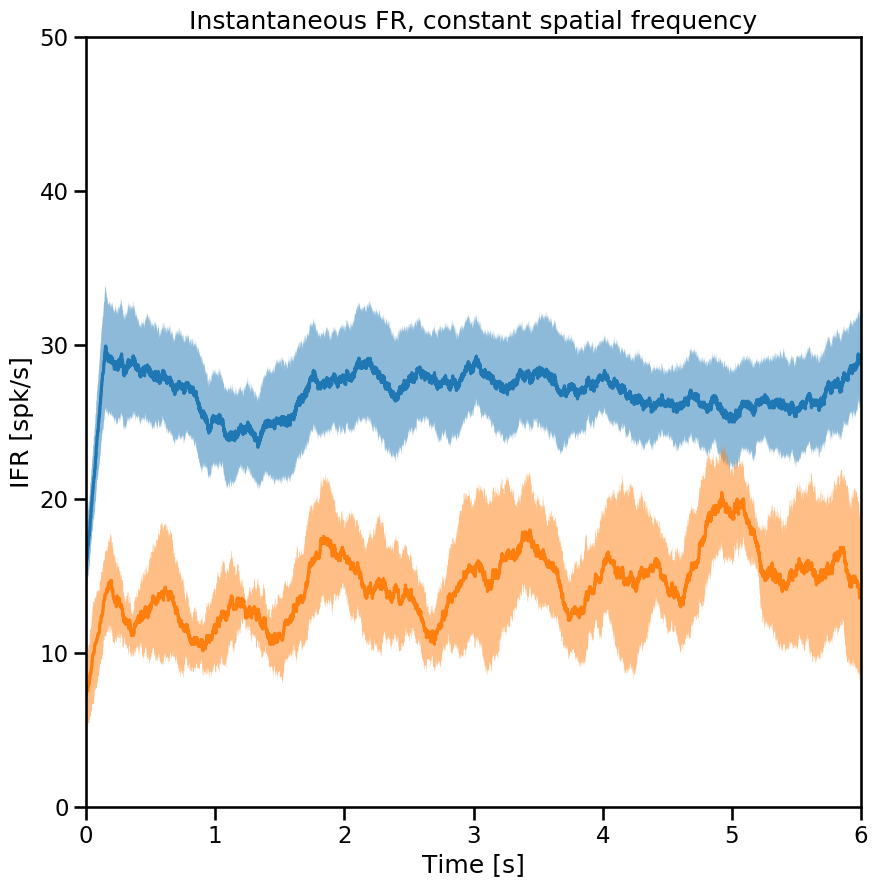

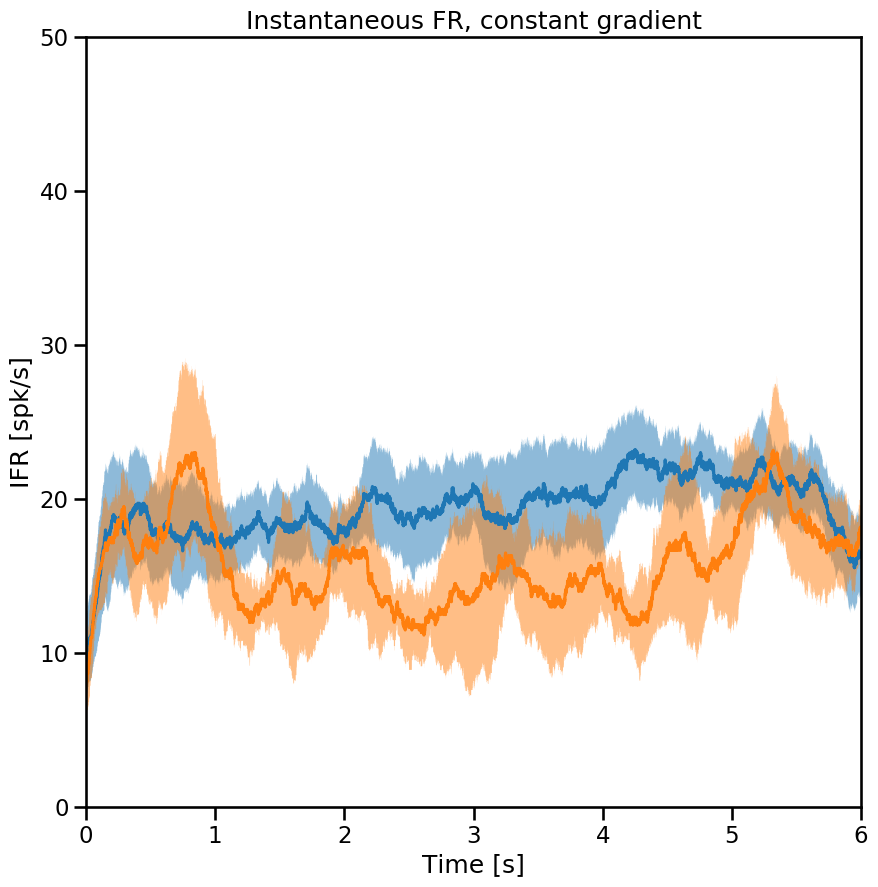

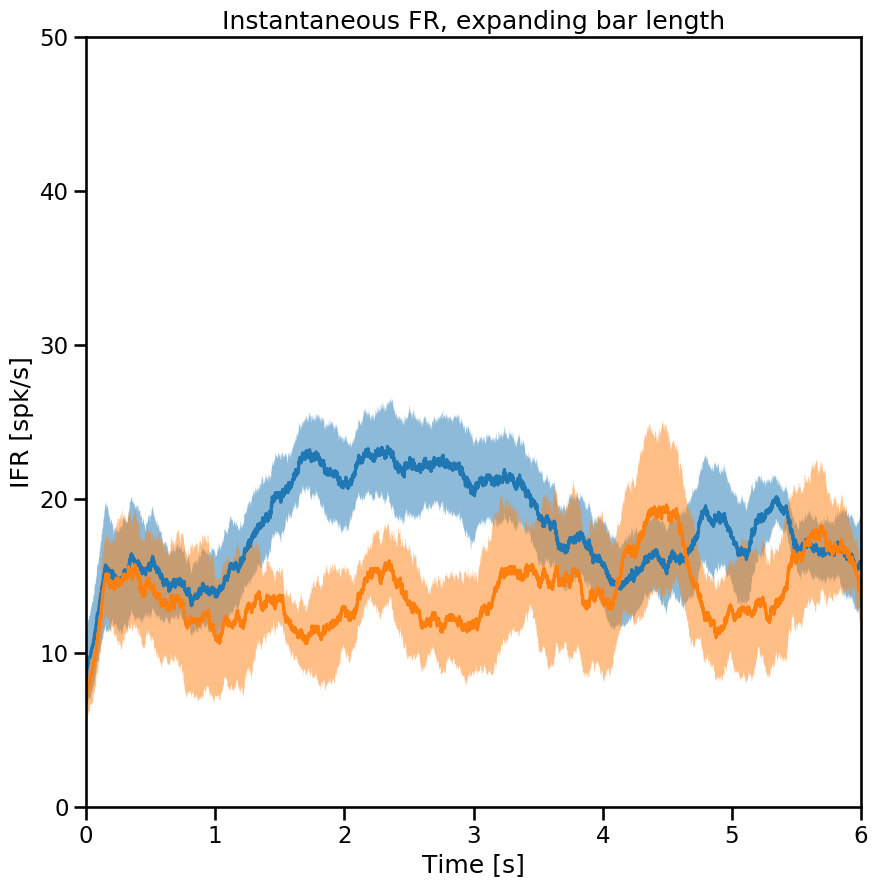

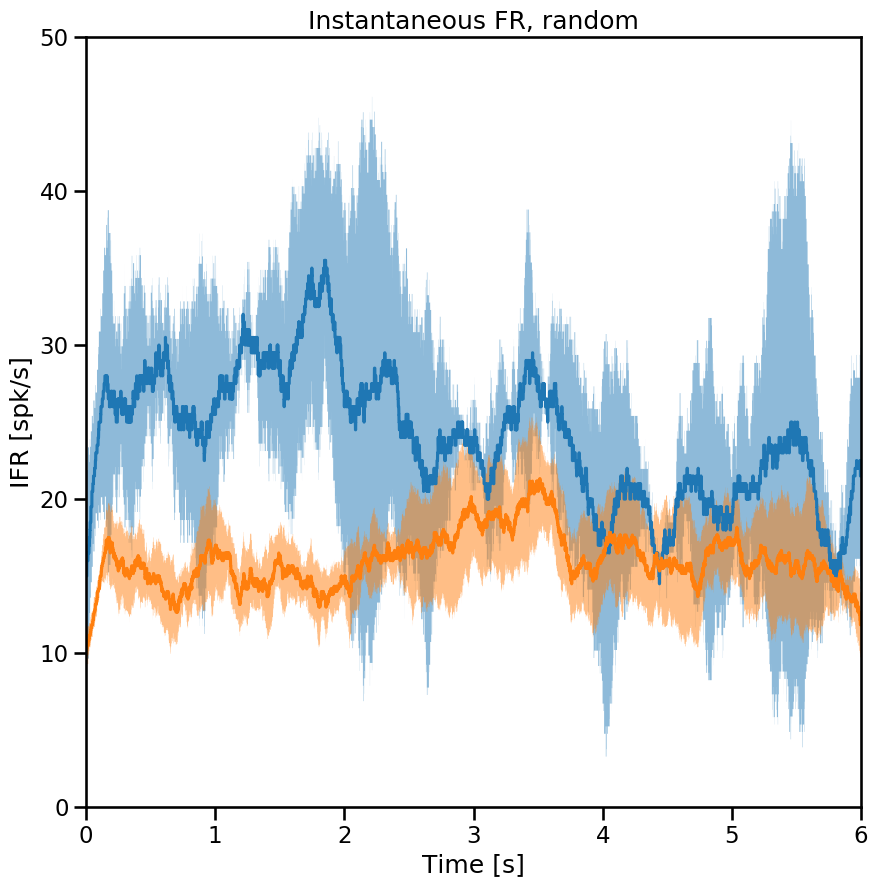

In [41]:
rcParams["figure.figsize"] = (10,10)
for i = 1 : 4
    figure()
    plot(sccw[i]["t_ifr"], sccw[i]["ifr"], label="CCW")
    fill_between(sccw[i]["t_ifr"], dropdims(sccw[i]["ifr"]-sccw[i]["ci95"], dims=2), dropdims(sccw[i]["ifr"]+sccw[i]["ci95"], dims=2), alpha=0.5)
    
    plot(scw[i]["t_ifr"], scw[i]["ifr"], label="CW")
    fill_between(scw[i]["t_ifr"], dropdims(scw[i]["ifr"]-scw[i]["ci95"], dims=2), dropdims(scw[i]["ifr"]+scw[i]["ci95"], dims=2), alpha=0.5)
    xlim([0, 6]) ; ylim([0, 50]) ; xlabel("Time [s]") ; ylabel("IFR [spk/s]")
    if i == 1
        title("Instantaneous FR, constant spatial frequency")
    elseif i == 2
        title("Instantaneous FR, constant gradient")
    elseif i == 3
        title("Instantaneous FR, expanding bar length")
    else
        title("Instantaneous FR, random")
    end
    savefig("figs/fig3-" * string(i) * ".png")
end

In [43]:
scw[1]["trl"]

Dict{Any,Any} with 7 entries:
  7 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985819, 0.985819, 0.985819, 0.…
  4 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985761, 0.985761, 0.985819, 0.…
  2 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985761, 0.985761, 0.985819, 0.…
  3 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985819, 0.985819, 0.985819, 0.…
  5 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985761, 0.985761, 0.985761, 0.…
  6 => Dict{Any,Any}("stim"=>Float32[0.985761, 0.985761, 0.985761, 0.985761, 0.…
  1 => Dict{Any,Any}("stim"=>Float32[0.988597, 0.985471, 0.98194, 0.97812, 0.97…